In [1]:
import math
import numpy as np
import torch
from tqdm import tqdm


Nx, Ny, Nz = 512, 512, 1
Deltaxy = 0.000125
DeltaZ = 0.0000625
ROIRadius = 0.032
FirstSliceNumber = 700

NViews = 225
NChan = 1024
DeltaCh = 0.0000625
CenterOff = 23.0
DeltaSlice = 0.0000625

LEN_PIX = 511
BIN = 1
OUT_A = "A_parallel_params512.npz"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32



# build uniform angle list
def make_angles(n, device, dtype):
    step = math.pi / n
    return torch.tensor([i * step for i in range(n)], dtype=dtype, device=device)

# get pixel center from flat index
def pixel_center(j, Nx, Ny, dxy):
    jx = j % Nx
    jy = j // Nx
    x = (jx - (Nx - 1) / 2.0) * dxy
    y = (jy - (Ny - 1) / 2.0) * dxy
    return x, y

# detector bin centers in mm
def det_centers(N, dch, off_bins, device, dtype):
    idx = torch.arange(N, dtype=dtype, device=device)
    return (idx - (N - 1) / 2.0 - off_bins) * dch

# trapezoid pixel footprints
def build_pixel_profiles(angles, DeltaPix, LEN_PIX, device, dtype):
    pi = math.pi
    rc = math.sin(pi / 4.0)
    P = torch.zeros((angles.numel(), LEN_PIX), dtype=dtype, device=device)
    for vi in range(angles.numel()):
        ang = float(angles[vi].item())
        while ang >= pi / 2.0:
            ang -= pi / 2.0
        while ang < 0.0:
            ang += pi / 2.0
        if ang <= pi / 4.0:
            maxval = DeltaPix / max(math.cos(ang), 1e-12)
        else:
            maxval = DeltaPix / max(math.cos(pi / 2.0 - ang), 1e-12)
        d1 = rc * math.cos(pi / 4.0 - ang)
        d2 = rc * abs(math.sin(pi / 4.0 - ang))
        t1 = 1.0 - d1
        t2 = 1.0 - d2
        t3 = 1.0 + d2
        t4 = 1.0 + d1
        for uj in range(LEN_PIX):
            t = 2.0 * uj / float(LEN_PIX)
            if (t <= t1) or (t > t4):
                val = 0.0
            elif t <= t2:
                val = maxval * (t - t1) / ((t2 - t1) if (t2 - t1) != 0.0 else 1e-12)
            elif t <= t3:
                val = maxval
            else:
                val = maxval * (t4 - t) / ((t4 - t3) if (t4 - t3) != 0.0 else 1e-12)
            P[vi, uj] = val
    return P

# detector bin window for a pixel
def channel_window(x, y, theta, DeltaPix, t0, DeltaCh, NChan):
    s0 = y * math.cos(theta) - x * math.sin(theta)
    t_min = s0 - DeltaPix
    t_max = s0 + DeltaPix
    i_min = math.ceil((t_min - t0) / DeltaCh - 0.5)
    i_max = math.floor((t_max - t0) / DeltaCh + 0.5)
    i_min = max(i_min, 0)
    i_max = min(i_max, NChan - 1)
    return i_min, i_max, s0

# profile sample index
def profile_index(t_i, s0, DeltaPix, LEN_PIX):
    u_float = ((t_i - s0) + DeltaPix) * (LEN_PIX - 1) / (2.0 * DeltaPix)
    u = int(math.floor(u_float + 0.5))
    if u < 0:
        return 0
    if u >= LEN_PIX:
        return LEN_PIX - 1
    return u

# build one column of A
def build_column(j, Nx, Ny, Deltaxy, angles, tcent, DeltaCh, LEN_PIX, P):
    NViews = angles.numel()
    NChan = tcent.numel()
    DeltaPix = Deltaxy
    t0 = float(tcent[0].item())
    x, y = pixel_center(j, Nx, Ny, Deltaxy)
    rows, vals = [], []
    for p in range(NViews):
        theta = float(angles[p].item())
        i_min, i_max, s0 = channel_window(x, y, theta, DeltaPix, t0, DeltaCh, NChan)
        if i_min > i_max:
            continue
        for i in range(i_min, i_max + 1):
            u = profile_index(float(tcent[i].item()), s0, DeltaPix, LEN_PIX)
            w = float(P[p, u].item())
            if w > 0.0:
                rows.append(p * NChan + i)
                vals.append(w)
    return rows, vals

# assemble and save A
def main():
    # --- Detector & angle setup ---
    nchan = NChan // BIN                       # effective detector bins
    dch = DeltaCh * BIN                        # effective channel spacing
    coff = CenterOff / BIN                     # adjusted center offset
    angles = make_angles(NViews, device, dtype)  # angle list
    tcent = det_centers(nchan, dch, coff, device, dtype)  # detector centers
    P = build_pixel_profiles(angles, Deltaxy, LEN_PIX, device, dtype)  # pixel profiles

    # --- Dimensions ---
    Nrows = NViews * nchan                     # number of measurements
    Ncols = Nx * Ny                            # number of pixels
    r_all, c_all, v_all = [], [], []           # sparse storage

    # --- Build A-matrix column by column ---
    for j in tqdm(range(Ncols), desc="Building A", unit="col"):
        rj, vj = build_column(
            j, Nx, Ny, Deltaxy,
            angles, tcent, dch,
            LEN_PIX, P
        )
        if rj:
            r_all.extend(rj)                   # row indices
            c_all.extend([j] * len(rj))        # col indices
            v_all.extend(vj)                   # values

    # --- Convert to numpy arrays ---
    r_all = np.asarray(r_all, dtype=np.int64)
    c_all = np.asarray(c_all, dtype=np.int64)
    v_all = np.asarray(v_all, dtype=np.float32)

    # --- Package into A-matrix dict ---
    a_matrix = {
        "row_idx_all": r_all,
        "col_idx_all": c_all,
        "val_all": v_all,
        "Nrows": np.int64(Nrows),
        "Ncols": np.int64(Ncols),
        "Nx": np.int64(Nx),
        "Ny": np.int64(Ny),
        "Nz": np.int64(Nz),
        "Deltaxy": np.float64(Deltaxy),
        "LEN_PIX": np.int64(LEN_PIX),
        "NViews": np.int64(NViews),
        "NChannels": np.int64(nchan),
        "DeltaChannel": np.float64(dch),
        "CenterOffset": np.float64(coff),
        "DeltaSlice": np.float64(DeltaSlice),
        "BIN": np.int64(BIN),
    }

    # --- Save A-matrix ---
    np.savez_compressed(OUT_A, **a_matrix)

    print(f"saved {OUT_A} | rows={Nrows} cols={Ncols} nnz={r_all.size}")


if __name__ == "__main__":
    main()


Building A: 100%|██████████| 262144/262144 [17:43<00:00, 246.43col/s]


saved A_parallel_params512.npz | rows=230400 cols=262144 nnz=140908314


dev: cpu
A: grid=(512,512,1) views=225 det=1024 nnz=140908314
sino: (225, 1, 1024) min/max: -0.11988259851932526 0.7530611753463745
||y||2: 158.57373046875 ||Ax0||2: 0.0
  25  L=2.988e+03  F=2.988e+03  TV=2.322e+04  lr=0.3
  50  L=4.796e+02  F=4.796e+02  TV=7.015e+04  lr=0.3
  75  L=3.498e+02  F=3.498e+02  TV=2.448e+05  lr=0.3
 100  L=2.958e+02  F=2.958e+02  TV=3.617e+05  lr=0.3
 125  L=2.649e+02  F=2.649e+02  TV=4.723e+05  lr=0.3
 150  L=2.450e+02  F=2.450e+02  TV=5.633e+05  lr=0.06
 175  L=2.414e+02  F=2.414e+02  TV=5.833e+05  lr=0.06
 200  L=2.384e+02  F=2.384e+02  TV=6.011e+05  lr=0.06
 225  L=2.355e+02  F=2.355e+02  TV=6.193e+05  lr=0.06
 250  L=2.327e+02  F=2.327e+02  TV=6.379e+05  lr=0.06
 275  L=2.300e+02  F=2.300e+02  TV=6.566e+05  lr=0.06
 300  L=2.274e+02  F=2.274e+02  TV=6.755e+05  lr=0.012
saved: mbir_reconstruction.npy


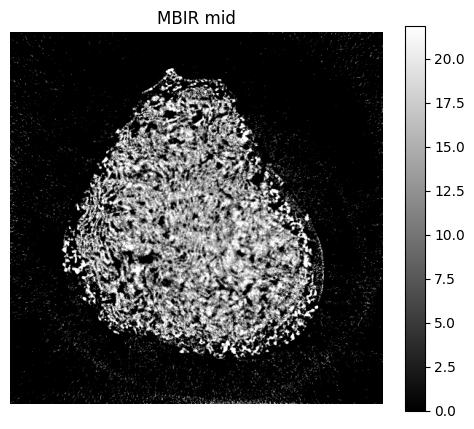

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# paths
A_PATH   = "A_parallel_params512.npz"
SINO_PATH= "xradia_slice0700.2Dsinodata"

# dev
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available(): torch.cuda.set_device(0)
print("dev:", device)

# load A
A = np.load(A_PATH)
row_idx = torch.tensor(A["row_idx_all"], dtype=torch.long, device=device)
col_idx = torch.tensor(A["col_idx_all"], dtype=torch.long, device=device)
aval    = torch.tensor(A["val_all"],     dtype=torch.float32, device=device)
Nx, Ny, Nz = int(A["Nx"]), int(A["Ny"]), int(A.get("Nz", 1))
V, C       = int(A["NViews"]), int(A["NChannels"])
print(f"A: grid=({Nx},{Ny},{Nz}) views={V} det={C} nnz={row_idx.numel()}")

# load sino
with open(SINO_PATH, "rb") as f:
    flat = np.frombuffer(f.read(), dtype=np.float32)
if flat.size not in (V*C, V*1*C):
    raise ValueError(f"bad size {flat.size}, want {V*C}")
s2d = flat.reshape(V, 1, C).astype(np.float32)
if Nz > 1:
    sino = np.zeros((V, Nz, C), dtype=np.float32)
    midz = Nz // 2
    sino[:, midz:midz+1, :] = s2d
else:
    sino = s2d
y = torch.tensor(sino, dtype=torch.float32, device=device)
print("sino:", tuple(y.shape), "min/max:", y.min().item(), y.max().item())

# projector
def proj_mid(xflat, recon_shape):
    Vloc, Nzloc, Cloc = V, recon_shape[2], C
    ncols = recon_shape[0]*recon_shape[1]
    if xflat.dim()==1: X = xflat.view(ncols, 1)
    else:              X = xflat
    ypred = torch.zeros((Vloc, Nzloc, Cloc), dtype=torch.float32, device=device)
    mid = Nzloc//2
    xmid = X[:, mid]
    yz = torch.zeros(Vloc*Cloc, dtype=torch.float32, device=device)
    yz.index_add_(0, row_idx, aval * xmid[col_idx])
    ypred[:, mid, :] = yz.view(Vloc, Cloc)
    return ypred

# tv (mid)
def tv_mid(x):
    eps = 1e-8
    z = x.shape[2]//2
    s = x[:,:,z].unsqueeze(0).unsqueeze(0)
    v = s[:,:,1:,:]-s[:,:,:-1,:]
    h = s[:,:,:,1:]-s[:,:,:,:-1]
    v = F.pad(v,(0,0,0,1)); h = F.pad(h,(0,1,0,0))
    return torch.sum(torch.sqrt(torch.clamp(v*v+h*h, min=eps)))

# loss
LAM = 0.0 #0.2
def loss_fn(x3d):
    Ax = proj_mid(x3d.view(-1, x3d.shape[2]), x3d.shape)
    mid = x3d.shape[2]//2
    Fterm = torch.sum((y[:,mid:mid+1,:] - Ax[:,mid:mid+1,:])**2)
    TV = tv_mid(x3d)
    return Fterm + LAM*TV, Fterm, TV

# init
x = torch.zeros((Nx, Ny, Nz), dtype=torch.float32, requires_grad=True, device=device)

# opt
opt = torch.optim.Adam([x], lr=0.3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=150, gamma=0.2)

# sanity
with torch.no_grad():
    Ax0 = proj_mid(x.view(-1, Nz), x.shape)
print("||y||2:", y.norm().item(), "||Ax0||2:", Ax0.norm().item())

# train
ITERS = 300
for it in range(1, ITERS+1):
    opt.zero_grad()
    total, Fterm, TV = loss_fn(x)
    total.backward()
    torch.nn.utils.clip_grad_norm_([x], 1.0)
    opt.step(); sched.step()
    with torch.no_grad(): x.clamp_(min=0.0)
    if it % 25 == 0:
        print(f"{it:4d}  L={total.item():.3e}  F={Fterm.item():.3e}  TV={TV.item():.3e}  lr={sched.get_last_lr()[0]:.3g}")

# save
np.save("mbir_reconstruction.npy", x.detach().cpu().numpy())
print("saved: mbir_reconstruction.npy")

# show
xnp = x.detach().cpu().numpy()
sl = xnp[:,:,Nz//2]
p2,p98 = np.percentile(sl,[2,98]);
if p2==p98: p2,p98 = sl.min(), sl.max()
plt.figure(figsize=(6,5))
plt.imshow(sl, cmap="gray", vmin=p2, vmax=p98); plt.axis("off"); plt.colorbar()
plt.title("MBIR mid"); plt.show()


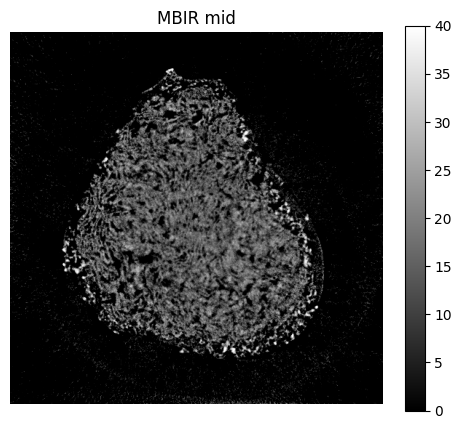

In [4]:
xnp = x.detach().cpu().numpy()
sl = xnp[:,:,Nz//2]
p2,p98 = np.percentile(sl,[2,98]);
if p2==p98: p2,p98 = sl.min(), sl.max()
plt.figure(figsize=(6,5))
plt.imshow(sl, cmap="gray", vmin=0, vmax=40); plt.axis("off"); plt.colorbar()
plt.title("MBIR mid"); plt.show()

In [5]:
import math
import numpy as np
import torch
from tqdm import tqdm


Nx, Ny, Nz = 1024, 1034, 1
Deltaxy = 0.0000625
DeltaZ = 0.0000625
ROIRadius = 0.032
FirstSliceNumber = 700

NViews = 225
NChan = 1024
DeltaCh = 0.0000625
CenterOff = 23.0
DeltaSlice = 0.0000625

LEN_PIX = 511
BIN = 1
OUT_A = "A_parallel_params1k.npz"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32



# build uniform angle list
def make_angles(n, device, dtype):
    step = math.pi / n
    return torch.tensor([i * step for i in range(n)], dtype=dtype, device=device)

# get pixel center from flat index
def pixel_center(j, Nx, Ny, dxy):
    jx = j % Nx
    jy = j // Nx
    x = (jx - (Nx - 1) / 2.0) * dxy
    y = (jy - (Ny - 1) / 2.0) * dxy
    return x, y

# detector bin centers in mm
def det_centers(N, dch, off_bins, device, dtype):
    idx = torch.arange(N, dtype=dtype, device=device)
    return (idx - (N - 1) / 2.0 - off_bins) * dch

# trapezoid pixel footprints
def build_pixel_profiles(angles, DeltaPix, LEN_PIX, device, dtype):
    pi = math.pi
    rc = math.sin(pi / 4.0)
    P = torch.zeros((angles.numel(), LEN_PIX), dtype=dtype, device=device)
    for vi in range(angles.numel()):
        ang = float(angles[vi].item())
        while ang >= pi / 2.0:
            ang -= pi / 2.0
        while ang < 0.0:
            ang += pi / 2.0
        if ang <= pi / 4.0:
            maxval = DeltaPix / max(math.cos(ang), 1e-12)
        else:
            maxval = DeltaPix / max(math.cos(pi / 2.0 - ang), 1e-12)
        d1 = rc * math.cos(pi / 4.0 - ang)
        d2 = rc * abs(math.sin(pi / 4.0 - ang))
        t1 = 1.0 - d1
        t2 = 1.0 - d2
        t3 = 1.0 + d2
        t4 = 1.0 + d1
        for uj in range(LEN_PIX):
            t = 2.0 * uj / float(LEN_PIX)
            if (t <= t1) or (t > t4):
                val = 0.0
            elif t <= t2:
                val = maxval * (t - t1) / ((t2 - t1) if (t2 - t1) != 0.0 else 1e-12)
            elif t <= t3:
                val = maxval
            else:
                val = maxval * (t4 - t) / ((t4 - t3) if (t4 - t3) != 0.0 else 1e-12)
            P[vi, uj] = val
    return P

# detector bin window for a pixel
def channel_window(x, y, theta, DeltaPix, t0, DeltaCh, NChan):
    s0 = y * math.cos(theta) - x * math.sin(theta)
    t_min = s0 - DeltaPix
    t_max = s0 + DeltaPix
    i_min = math.ceil((t_min - t0) / DeltaCh - 0.5)
    i_max = math.floor((t_max - t0) / DeltaCh + 0.5)
    i_min = max(i_min, 0)
    i_max = min(i_max, NChan - 1)
    return i_min, i_max, s0

# profile sample index
def profile_index(t_i, s0, DeltaPix, LEN_PIX):
    u_float = ((t_i - s0) + DeltaPix) * (LEN_PIX - 1) / (2.0 * DeltaPix)
    u = int(math.floor(u_float + 0.5))
    if u < 0:
        return 0
    if u >= LEN_PIX:
        return LEN_PIX - 1
    return u

# build one column of A
def build_column(j, Nx, Ny, Deltaxy, angles, tcent, DeltaCh, LEN_PIX, P):
    NViews = angles.numel()
    NChan = tcent.numel()
    DeltaPix = Deltaxy
    t0 = float(tcent[0].item())
    x, y = pixel_center(j, Nx, Ny, Deltaxy)
    rows, vals = [], []
    for p in range(NViews):
        theta = float(angles[p].item())
        i_min, i_max, s0 = channel_window(x, y, theta, DeltaPix, t0, DeltaCh, NChan)
        if i_min > i_max:
            continue
        for i in range(i_min, i_max + 1):
            u = profile_index(float(tcent[i].item()), s0, DeltaPix, LEN_PIX)
            w = float(P[p, u].item())
            if w > 0.0:
                rows.append(p * NChan + i)
                vals.append(w)
    return rows, vals

# assemble and save A
def main():
    # --- Detector & angle setup ---
    nchan = NChan // BIN                       # effective detector bins
    dch = DeltaCh * BIN                        # effective channel spacing
    coff = CenterOff / BIN                     # adjusted center offset
    angles = make_angles(NViews, device, dtype)  # angle list
    tcent = det_centers(nchan, dch, coff, device, dtype)  # detector centers
    P = build_pixel_profiles(angles, Deltaxy, LEN_PIX, device, dtype)  # pixel profiles

    # --- Dimensions ---
    Nrows = NViews * nchan                     # number of measurements
    Ncols = Nx * Ny                            # number of pixels
    r_all, c_all, v_all = [], [], []           # sparse storage

    # --- Build A-matrix column by column ---
    for j in tqdm(range(Ncols), desc="Building A", unit="col"):
        rj, vj = build_column(
            j, Nx, Ny, Deltaxy,
            angles, tcent, dch,
            LEN_PIX, P
        )
        if rj:
            r_all.extend(rj)                   # row indices
            c_all.extend([j] * len(rj))        # col indices
            v_all.extend(vj)                   # values

    # --- Convert to numpy arrays ---
    r_all = np.asarray(r_all, dtype=np.int64)
    c_all = np.asarray(c_all, dtype=np.int64)
    v_all = np.asarray(v_all, dtype=np.float32)

    # --- Package into A-matrix dict ---
    a_matrix = {
        "row_idx_all": r_all,
        "col_idx_all": c_all,
        "val_all": v_all,
        "Nrows": np.int64(Nrows),
        "Ncols": np.int64(Ncols),
        "Nx": np.int64(Nx),
        "Ny": np.int64(Ny),
        "Nz": np.int64(Nz),
        "Deltaxy": np.float64(Deltaxy),
        "LEN_PIX": np.int64(LEN_PIX),
        "NViews": np.int64(NViews),
        "NChannels": np.int64(nchan),
        "DeltaChannel": np.float64(dch),
        "CenterOffset": np.float64(coff),
        "DeltaSlice": np.float64(DeltaSlice),
        "BIN": np.int64(BIN),
    }

    # --- Save A-matrix ---
    np.savez_compressed(OUT_A, **a_matrix)

    print(f"saved {OUT_A} | rows={Nrows} cols={Ncols} nnz={r_all.size}")


if __name__ == "__main__":
    main()


Building A: 100%|██████████| 1058816/1058816 [45:43<00:00, 385.93col/s] 


saved A_parallel_params1k.npz | rows=230400 cols=1058816 nnz=283916476


dev: cpu
A: grid=(1024,1034,1) views=225 det=1024 nnz=283916476
sino: (225, 1, 1024) min/max: -0.11988259851932526 0.7530611753463745
||y||2: 158.57373046875 ||Ax0||2: 0.0
  25  L=2.974e+03  F=2.974e+03  TV=2.034e+05  lr=0.3
  50  L=5.066e+02  F=5.066e+02  TV=4.709e+05  lr=0.3
  75  L=3.784e+02  F=3.784e+02  TV=1.211e+06  lr=0.3
 100  L=3.231e+02  F=3.231e+02  TV=1.821e+06  lr=0.3
 125  L=2.860e+02  F=2.860e+02  TV=2.319e+06  lr=0.3
 150  L=2.591e+02  F=2.591e+02  TV=2.775e+06  lr=0.06
 175  L=2.538e+02  F=2.538e+02  TV=2.870e+06  lr=0.06
 200  L=2.494e+02  F=2.494e+02  TV=2.954e+06  lr=0.06
 225  L=2.450e+02  F=2.450e+02  TV=3.041e+06  lr=0.06
 250  L=2.406e+02  F=2.406e+02  TV=3.129e+06  lr=0.06
 275  L=2.364e+02  F=2.364e+02  TV=3.219e+06  lr=0.06
 300  L=2.323e+02  F=2.323e+02  TV=3.308e+06  lr=0.012
saved: mbir_reconstruction.npy


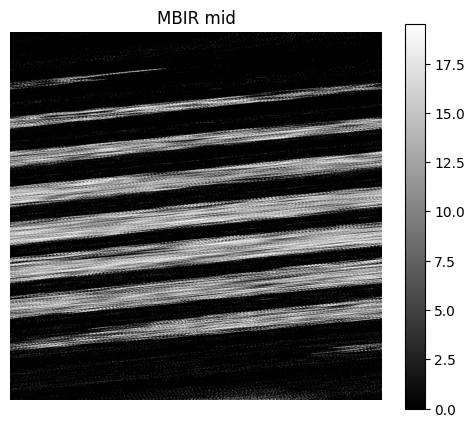

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# paths
A_PATH   = "A_parallel_params1k.npz"
SINO_PATH= "xradia_slice0700.2Dsinodata"

# dev
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available(): torch.cuda.set_device(0)
print("dev:", device)

# load A
A = np.load(A_PATH)
row_idx = torch.tensor(A["row_idx_all"], dtype=torch.long, device=device)
col_idx = torch.tensor(A["col_idx_all"], dtype=torch.long, device=device)
aval    = torch.tensor(A["val_all"],     dtype=torch.float32, device=device)
Nx, Ny, Nz = int(A["Nx"]), int(A["Ny"]), int(A.get("Nz", 1))
V, C       = int(A["NViews"]), int(A["NChannels"])
print(f"A: grid=({Nx},{Ny},{Nz}) views={V} det={C} nnz={row_idx.numel()}")

# load sino
with open(SINO_PATH, "rb") as f:
    flat = np.frombuffer(f.read(), dtype=np.float32)
if flat.size not in (V*C, V*1*C):
    raise ValueError(f"bad size {flat.size}, want {V*C}")
s2d = flat.reshape(V, 1, C).astype(np.float32)
if Nz > 1:
    sino = np.zeros((V, Nz, C), dtype=np.float32)
    midz = Nz // 2
    sino[:, midz:midz+1, :] = s2d
else:
    sino = s2d
y = torch.tensor(sino, dtype=torch.float32, device=device)
print("sino:", tuple(y.shape), "min/max:", y.min().item(), y.max().item())

# projector
def proj_mid(xflat, recon_shape):
    Vloc, Nzloc, Cloc = V, recon_shape[2], C
    ncols = recon_shape[0]*recon_shape[1]
    if xflat.dim()==1: X = xflat.view(ncols, 1)
    else:              X = xflat
    ypred = torch.zeros((Vloc, Nzloc, Cloc), dtype=torch.float32, device=device)
    mid = Nzloc//2
    xmid = X[:, mid]
    yz = torch.zeros(Vloc*Cloc, dtype=torch.float32, device=device)
    yz.index_add_(0, row_idx, aval * xmid[col_idx])
    ypred[:, mid, :] = yz.view(Vloc, Cloc)
    return ypred

# tv (mid)
def tv_mid(x):
    eps = 1e-8
    z = x.shape[2]//2
    s = x[:,:,z].unsqueeze(0).unsqueeze(0)
    v = s[:,:,1:,:]-s[:,:,:-1,:]
    h = s[:,:,:,1:]-s[:,:,:,:-1]
    v = F.pad(v,(0,0,0,1)); h = F.pad(h,(0,1,0,0))
    return torch.sum(torch.sqrt(torch.clamp(v*v+h*h, min=eps)))

# loss
LAM = 0.0 #0.2
def loss_fn(x3d):
    Ax = proj_mid(x3d.view(-1, x3d.shape[2]), x3d.shape)
    mid = x3d.shape[2]//2
    Fterm = torch.sum((y[:,mid:mid+1,:] - Ax[:,mid:mid+1,:])**2)
    TV = tv_mid(x3d)
    return Fterm + LAM*TV, Fterm, TV

# init
x = torch.zeros((Nx, Ny, Nz), dtype=torch.float32, requires_grad=True, device=device)

# opt
opt = torch.optim.Adam([x], lr=0.3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=150, gamma=0.2)

# sanity
with torch.no_grad():
    Ax0 = proj_mid(x.view(-1, Nz), x.shape)
print("||y||2:", y.norm().item(), "||Ax0||2:", Ax0.norm().item())

# train
ITERS = 300
for it in range(1, ITERS+1):
    opt.zero_grad()
    total, Fterm, TV = loss_fn(x)
    total.backward()
    torch.nn.utils.clip_grad_norm_([x], 1.0)
    opt.step(); sched.step()
    with torch.no_grad(): x.clamp_(min=0.0)
    if it % 25 == 0:
        print(f"{it:4d}  L={total.item():.3e}  F={Fterm.item():.3e}  TV={TV.item():.3e}  lr={sched.get_last_lr()[0]:.3g}")

# save
np.save("mbir_reconstruction1k.npy", x.detach().cpu().numpy())
print("saved: mbir_reconstruction.npy")

# show
xnp = x.detach().cpu().numpy()
sl = xnp[:,:,Nz//2]
p2,p98 = np.percentile(sl,[2,98]);
if p2==p98: p2,p98 = sl.min(), sl.max()
plt.figure(figsize=(6,5))
plt.imshow(sl, cmap="gray", vmin=p2, vmax=p98); plt.axis("off"); plt.colorbar()
plt.title("MBIR mid"); plt.show()


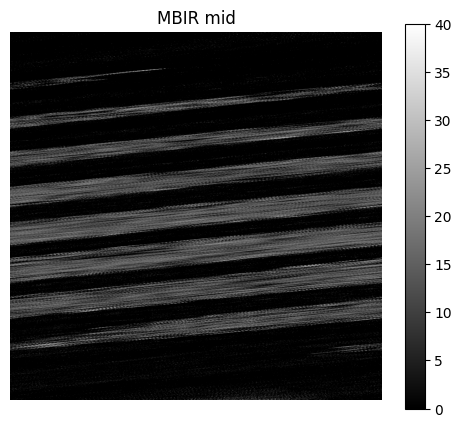

In [7]:
xnp = x.detach().cpu().numpy()
sl = xnp[:,:,Nz//2]
p2,p98 = np.percentile(sl,[2,98]);
if p2==p98: p2,p98 = sl.min(), sl.max()
plt.figure(figsize=(6,5))
plt.imshow(sl, cmap="gray", vmin=0, vmax=40); plt.axis("off"); plt.colorbar()
plt.title("MBIR mid"); plt.show()